# Tracking a Dynamic System (Model-Based)
In this notebook we simualte model-based tracking of a dynamic system. 
We shall focus on the problem known in the lterature as *filtering*, where the goal is to identify an estimate of a state variable ${\boldsymbol s}_t$ from past observatsion $\{{\boldsymbol x}_\tau\}_{\tau \leq t}$, i.e.,
\begin{equation}
\hat{\boldsymbol s}_t = f\left(\{{\boldsymbol x}_\tau\}_{\tau \leq t}\right).
\end{equation}
The objective is the MSE, namely
\begin{equation}
\mathcal{L}(f) = \mathbb{E}\{\|\hat{\boldsymbol s}_t-{\boldsymbol s}_t\|_2^2\}.
\end{equation}

While we are not going to use deep learning, and implement model-based tracking, we still import pytorch just so that the optimizer we end up designing can be interpreted as some for of a neural network in future lectures.


In [11]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import torch.nn as nn

np.random.seed(0)

## Kalman Filter
When the statitical relationship between the state ${\boldsymbol s}_t$ and the observations ${\boldsymbol x}_t$ are known to obey a *linear Gaussian state-space model*, then the MSE optimal filter is the Kalman filter. 

A linear Guassian state-space model is formulated as
\begin{align}
        {\boldsymbol s}_{t+1} &= {\boldsymbol F}{\boldsymbol s}_t + {\boldsymbol v}_t, \qquad {\boldsymbol v}_t\sim \mathcal{N}(0, {\boldsymbol{V}}), \\
        {\boldsymbol x}_t &=  {\boldsymbol H}{\boldsymbol s}_{t} +{\boldsymbol w}_t, \qquad {\boldsymbol w}_t\sim \mathcal{N}(0, {\boldsymbol{W}}).
\end{align}
Thus, the objective parameters are 
	\begin{equation} 
	    {\boldsymbol \psi} = \{{\boldsymbol F}, {\boldsymbol H}, {\boldsymbol V}, {\boldsymbol W}\}.
	\end{equation}


  When the above model holds and is fully known, the Kalman filter minimizes the MSE by operating recursively, where it first uses the previous estimate, detnoted $\hat{\boldsymbol s}_{t-1}$ to produce a prediction of ${\boldsymbol s}_{t}$ and its covariance; then, the incoming observation ${\boldsymbol x}_t$ is used to update the prediction. 

  Mathematically, the *predict* step implements
  \begin{align}
  \hat{\boldsymbol s}_{t|t-1} &= {\boldsymbol F}\hat{\boldsymbol s}_{t-1}, \\
  {\boldsymbol \Sigma}_{t|t-1} &= {\boldsymbol F}{\boldsymbol \Sigma}_{t-1}{\boldsymbol F}^T + {\boldsymbol V}.
  \end{align}
  
  Th *update* step uses the prediction of ${\boldsymbol s}_{t}$ to predict ${\boldsymbol x}_t$  via
  \begin{align}
  \hat{\boldsymbol x}_{t|t-1} &= {\boldsymbol H}\hat{\boldsymbol s}_{t|t-1}, \\
  {\boldsymbol Q}_{t} &= {\boldsymbol H}{\boldsymbol \Sigma}_{t|t-1}{\boldsymbol H}^T + {\boldsymbol W}.
  \end{align}
  Then,  the incoming observation ${\boldsymbol x}_t$ is used to estimate the state and is covariance via
    \begin{align}
      \hat{\boldsymbol s}_{t} &= \hat{\boldsymbol s}_{t|t-1} +{\boldsymbol K}_t({\boldsymbol x}_t - \hat{{\boldsymbol x}}_{t|t-1}), \\
       {\boldsymbol \Sigma}_{t} &= {\boldsymbol \Sigma}_{t|t-1} - {\boldsymbol K}_t {\boldsymbol H} {\boldsymbol \Sigma}_{t|t-1}, \\
      {\boldsymbol K}_t &=  {\boldsymbol \Sigma}_{t|t-1} {\boldsymbol H}^T{\boldsymbol Q}_{t}^{-1}.
  \end{align}
  The matrix ${\boldsymbol K}_t $ is referred to as the *Kalman gain*.

In [12]:
# Kalman filter
class KalmanFilt(nn.Module):
    def __init__(self, F, H, V, W, StateInit):
        super(KalmanFilt, self).__init__()
  
        self.F = F 
        self.H = H
        self.V = V
        self.W = W

        # tracked sigma
        self.Sigma = np.eye(self.F.shape[1])
        # tracked state
        self.s = StateInit


    def predict(self):
        # Update time state
        self.s = np.dot(self.F, self.s) 

        # Calculate error covariance
        # Sigma= F*Sigma*F' + V
        self.Sigma = np.dot(np.dot(self.F, self.Sigma), self.F.T) + self.V
 

    def update(self, x):
        # S = H*P*H'+W
        S = np.dot(self.H, np.dot(self.Sigma, self.H.T)) + self.W

        # Calculate the Kalman Gain
        # K = Sigma * H'* inv(H*Sigma*H'+W)
        K = np.dot(np.dot(self.Sigma, self.H.T), np.linalg.inv(S)) 

        self.s = (self.s + np.dot(K, (x - np.dot(self.H, self.s))))  

        I = np.eye(self.H.shape[1])
        self.Sigma = (I - (K * self.H)) * self.Sigma 

    def forward(self, x):
        # First perdict next state without observation
        self.predict()
        # Then use observation to refine update
        self.update(x)

        return self.s

# Track moving object
We consider the tracking of a moving object in 1-D. In this case, the state vector is the position and the velocity of the object, i.e., 
\begin{equation}
\boldsymbol{s}_t = \left[p_t \quad \nu_t:=\frac{\partial p_t}{\partial t}\right]^T
\end{equation}
Assuming that we are sampling the system every $\Delta t$ seconds, we can write
\begin{equation}
p_{t+1}=p_t +  \Delta t \cdot \nu_t + \frac{1}{2}(\Delta t)^2 \ldots
\end{equation}
and
\begin{equation}
\nu_{t+1}=\nu_t +  (\Delta t) \ldots
\end{equation}
By modelling all the unknown terms as a Gaussian random vector $\boldsymbol{v}_t$, we obtain the state evolution model
\begin{equation}
\boldsymbol{s}_{t+1}=\left[\begin{array}~1 & \Delta t \\ 0 & 1 \end{array} \right]\boldsymbol{s}_{t} +\boldsymbol{v}_t, \qquad \boldsymbol{v}_t \sim \mathcal{N}\left( 0, \boldsymbol{V} = \left[\begin{array}~\frac{1}{4}(\Delta t)^4 & \frac{1}{2}(\Delta t)^3 \\ \frac{1}{2}(\Delta t)^3 & (\Delta t)^2 \end{array} \right]\cdot \sigma_v^2\right).
\end{equation}

It is emphasized that the goal here is to track the moving object, namely, to estimate the position $p_t$. The state-space model thus accomadates an additional variable -- the velocity $\nu_t$ -- in which we are not necessarily interested, but whose presence provides us additional domain knowledge which we can expoit during tracking.


In [13]:
dt = 0.1
sigma_v = 0.5

F = np.matrix([[1, dt],
               [0, 1]])

V = np.matrix([[(dt**4)/4, (dt**3)/2],
               [(dt**3)/2, dt**2]]) * sigma_v**2


We are obeserving noisy measurements of the position, namely 
\begin{equation}
x_t = [1 \quad 0]\boldsymbol{s}_t + w_t, \qquad w_t \sim \mathcal{N}(0,\sigma_w^2).
\end{equation}


In [14]:
H = np.matrix([[1, 0]])

sigma_w = 2


The following function generates a single trajectory from a the above state-space model

In [15]:
def get_trajectory(trajectory_time, stateInit, F, H, V, W):
  position = []
  measurements = []
  # intiial state - zero position and constant velocity
  state = stateInit

  for t in trajectory_time: 
    state = np.dot(F, state) + np.dot(V,np.random.normal(size=(state.size,1))) 
    position.append(state.item(0))
    observation = np.dot(H, state) +   np.dot(W, np.random.normal(size=(H.shape[0],1)))
    measurements.append(observation.item(0)) 

  return position, measurements

Let's generate a trajectory spanning 20 seconds starting from position $0$ with initial velocity $1$ [m/sec].

In [16]:
trajectory_time = np.arange(0, 20, dt) 
stateInit =  np.array([[0], [1]]) 
position, measurements = get_trajectory(trajectory_time, stateInit, F, H, sqrtm(V), sigma_w)

Visualizing the trajectory:

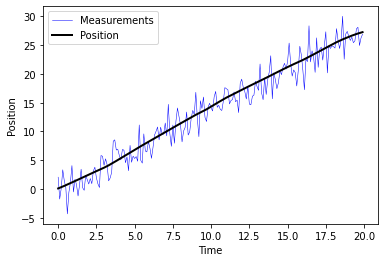

In [17]:
fig = plt.figure()
plt.plot(trajectory_time, measurements, label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, position, label='Position', color='k', linewidth=2)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show()

We note that the observations are very noisy, implying that tracking the trajectory is likely to be a challenging taks.


### Applying the Kalman filter with full domain knowledge
We can now apply the Kalman filter to the simulated trajecry

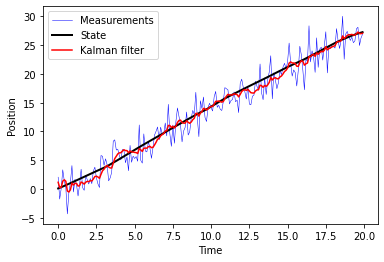

The estimation MSE is: 0.49151677473594996


In [18]:
from operator import add, sub

kf = KalmanFilt(F, H, V, sigma_w, stateInit)
predictions = [] 

for x in measurements:  
  state, error = kf(x)
  predictions.append(kf(x).item(0)) 
  
fig = plt.figure()
plt.plot(trajectory_time, measurements, label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, position, label='State', color='k', linewidth=2)
plt.plot(trajectory_time, predictions, label='Kalman filter', color='r', linewidth=1.5) 
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show() 

print('The estimation MSE is:',np.average((position - np.squeeze(predictions))**2))

We can see that the Kalman filter does a pretty good job in tracking the trajectory (it is actually the best performance one can achieve in terms of MSE). 


### Applying the Kalman filter with full domain knowledge
We previously applied the Kalman filter to the simualted trajectory; the achieved performance relies on prior knowledge of the model used to generate the data. What happens if there is some mismatch in the domain knowledge? we shall consider two cases:

1. What if instead of the true $\boldsymbol F$, the Kalman filter was operating with a slightly rotated version (by merely $\alpha = 0.01$ [rad])?

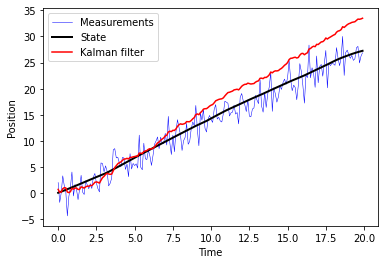

The estimation MSE is: 9.405302702767761


In [19]:
alpha = 0.01
RotMat = np.matrix([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)] ])
kf2 = KalmanFilt(np.dot(RotMat,F), H, V, sigma_w, stateInit)
predictions = []
for x in measurements:  
  predictions.append(kf2(x).item(0))

fig = plt.figure()
plt.plot(trajectory_time, measurements, label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, position, label='State', color='k', linewidth=2)
plt.plot(trajectory_time, predictions, label='Kalman filter', color='r', linewidth=1.5)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show() 


print('The estimation MSE is:',np.average((position - np.squeeze(predictions))**2))

We can clearly see that the mismatch notably degraded the performance and resulted in a drift in the tracked trajectory.

2. What if instead of the true $\boldsymbol V$, the Kalman filter was operating with estimating the noise as being saptailly i.i.d.?

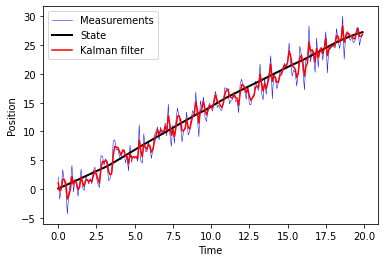

The estimation MSE is: 1.415291268943249


In [20]:
kf3 = KalmanFilt(np.dot(RotMat,F), H, np.eye(2), sigma_w, stateInit)
predictions = []
for x in measurements:  
  predictions.append(kf3(x).item(0))

fig = plt.figure()
plt.plot(trajectory_time, measurements, label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, position, label='State', color='k', linewidth=2)
plt.plot(trajectory_time, predictions, label='Kalman filter', color='r', linewidth=1.5)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show() 


print('The estimation MSE is:',np.average((position - np.squeeze(predictions))**2))